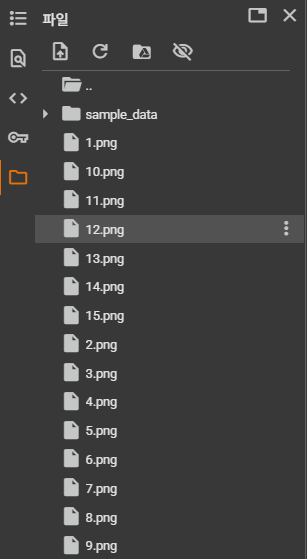

In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm


## 📦 라이브러리 불러오기
데이터 처리, 시각화, 모델 구축을 위한 필수 라이브러리를 불러옵니다.

In [ ]:
def load_images_from_folder(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = cv2.imread(filename)
        if img is not None: # Check if image was loaded successfully
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(label)
        else:
            print(f"Warning: Could not load image {filename}") # Optional: print a warning for debugging
    return images, labels

normal_imgs, normal_labels = load_images_from_folder('/content/', 0)
scratch_imgs, scratch_labels = load_images_from_folder('/content/sample_data/', 1)

X = np.array(normal_imgs + scratch_imgs)
y = np.array(normal_labels + scratch_labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 🖼️ 이미지 로딩 함수
정상/불량 이미지를 폴더에서 불러오고 전처리(리사이즈, 정규화)를 수행하는 함수입니다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class VentDataset(Dataset):
    def __init__(self, images, labels):
        self.x = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = VentDataset(X_train, y_train)
val_ds = VentDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)


## 📁 학습/검증 데이터 분할
불러온 이미지를 학습용과 검증용으로 나누고 Numpy 배열로 구성합니다.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16*64*64, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)



## 🧪 데이터 증강 및 커스텀 Dataset 정의
학습 데이터에만 적용할 이미지 증강(transform) 정의 및 PyTorch Dataset 클래스를 구현합니다.

In [ ]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {running_loss / len(train_dl):.4f}")


[Epoch 1] Loss: 0.6226
[Epoch 2] Loss: 0.0000
[Epoch 3] Loss: 0.0000
[Epoch 4] Loss: 0.0000
[Epoch 5] Loss: 0.0000
[Epoch 6] Loss: 0.0000
[Epoch 7] Loss: 0.0000
[Epoch 8] Loss: 0.0000
[Epoch 9] Loss: 0.0000
[Epoch 10] Loss: 0.0000


## 🔧 눌림/찍힘 증강 함수
기존 정상 이미지를 활용하여 눌림/찍힘 불량 이미지를 인위적으로 생성하는 함수입니다.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    all_true, all_preds,
    labels=[0, 1],
    target_names=["Normal", "Scratch"]
))


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         3
     Scratch       0.00      0.00      0.00         0

    accuracy                           1.00         3
   macro avg       0.50      0.50      0.50         3
weighted avg       1.00      1.00      1.00         3



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

## 🧱 증강된 이미지 추가
눌림 및 찍힘 이미지를 원본 학습 데이터에 추가하여 모델이 인식할 수 있도록 확장합니다.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from 

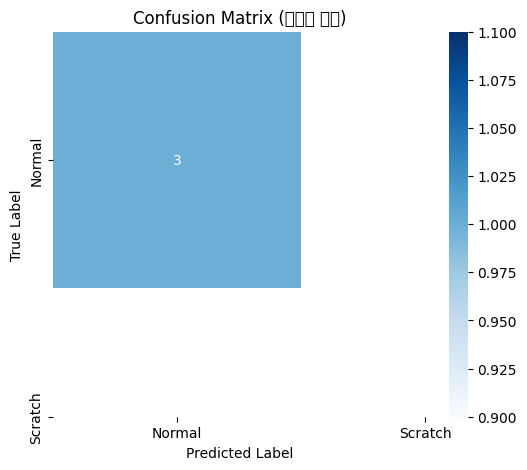

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 기존 예측 결과 사용
cm = confusion_matrix(all_true, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Scratch"],
            yticklabels=["Normal", "Scratch"])
plt.title("Confusion Matrix (정확도 포함)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## 🔄 DataLoader 정의
학습/검증 데이터를 배치 단위로 모델에 공급할 수 있도록 DataLoader 객체로 구성합니다.

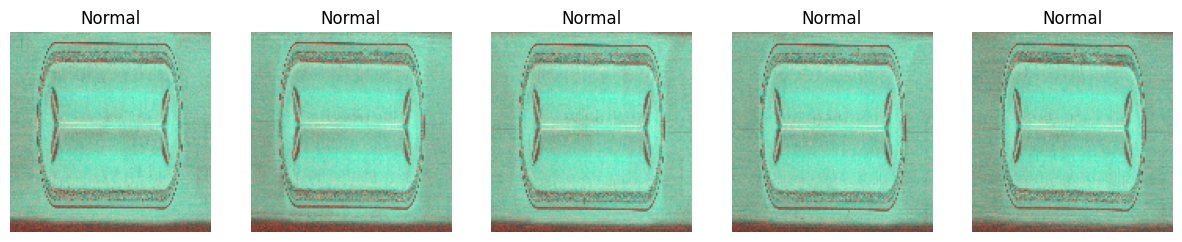

<Figure size 1500x300 with 0 Axes>

In [ ]:
# 클래스별 시각화 (임의 샘플)
import random

def show_class_samples(images, labels, class_idx, class_name, count=5):
    idxs = np.where(np.array(labels) == class_idx)[0]
    sample_idxs = random.sample(list(idxs), min(count, len(idxs)))

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(sample_idxs):
        img = images[idx]
        plt.subplot(1, count, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')
    plt.show()

# 정상 클래스 (0)
show_class_samples(X_train, y_train, class_idx=0, class_name="Normal")

# 불량 클래스 (1: Scratch)
show_class_samples(X_train, y_train, class_idx=1, class_name="Scratch")


## 🧠 간단한 CNN 모델 정의
3채널 입력을 받아 4개의 클래스(Normal, Scratch, Pressed, Dented)를 분류하는 간단한 CNN 구조입니다.

In [ ]:
import cv2

def apply_press_effect(image):
    h, w, _ = image.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, (w//2, h//2), min(h, w)//4, 255, -1)
    pressed = cv2.addWeighted(image, 1.0, cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)/255.0, -0.4, 0)
    return pressed.clip(0, 1)


## 🏋️ 모델 학습 루프
모델을 학습시키며 손실 값을 출력합니다. 옵티마이저는 Adam을 사용합니다.

In [ ]:
def apply_scratch_effect(image):
    noisy = image.copy()
    h, w, _ = noisy.shape
    for _ in range(10):
        x, y = np.random.randint(0, w), np.random.randint(0, h)
        r = np.random.randint(2, 5)
        cv2.circle(noisy, (x, y), r, (0, 0, 0), -1)
    return noisy
